# Technical Indicators Feature Analysis
## Exploratory Data Analysis for BTC/USDT Trading Features

This notebook analyzes engineered technical indicators derived from raw BTC/USDT trading data.

**Author**: Research Team  
**Date**: November 2025  
**Data Source**: Binance Exchange (BTC/USDT)

## 1. Environment Setup and Data Loading

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.6f' % x)

print("Environment setup complete!")

Environment setup complete!


In [2]:
# Load training and testing indicator datasets
train_indicators = pd.read_csv('training_indicators5.csv')
test_indicators = pd.read_csv('testing_indicators5.csv')

print("Training set shape:", train_indicators.shape)
print("Testing set shape:", test_indicators.shape)
print("\nTraining set info:")
print(train_indicators.info())

Training set shape: (21404, 18)
Testing set shape: (6153, 18)

Training set info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21404 entries, 0 to 21403
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   delta price_t      21404 non-null  float64
 1   delta price_t-1    21404 non-null  float64
 2   delta price_t-2    21404 non-null  float64
 3   delta price_t-3    21404 non-null  float64
 4   delta price_t-4    21404 non-null  float64
 5   delta price_t-5    21404 non-null  float64
 6   delta price_t-6    21404 non-null  float64
 7   delta price_t-7    21404 non-null  float64
 8   order imbalance    21404 non-null  float64
 9   macd signal        21404 non-null  float64
 10  spread             21404 non-null  float64
 11  mid price          21404 non-null  float64
 12  ADX                21404 non-null  float64
 13  RSI                21404 non-null  float64
 14  open interest      21404 non-null  f

## 2. Feature Engineering Overview

### 2.1 Feature Categories

The dataset contains **18 engineered features** organized into the following categories:

#### Price Momentum Features (8 features)
- `delta price_t` to `delta price_t-7`: Price changes over 8 time lags
- Captures short-term price momentum patterns

#### Market Microstructure (1 feature)
- `order imbalance`: Difference between bid and ask order volumes
- Measures buying vs selling pressure

#### Technical Indicators (7 features)
- `macd signal`: Moving Average Convergence Divergence signal line
- `spread`: Bid-ask spread (market liquidity measure)
- `mid price`: Average of bid and ask prices
- `ADX`: Average Directional Index (trend strength)
- `RSI`: Relative Strength Index (momentum oscillator)
- `open interest`: Total open positions
- `vol`: Trading volume

#### Target Variables (2 features)
- `future 10t return`: Forward 10-period return (prediction target)
- `ATR%`: Average True Range percentage (volatility measure)

## 2.2 Feature Engineering Methodology & Mathematical Derivations

### Why Feature Engineering Matters

Raw trading data (prices, volumes, order book) needs transformation to become useful for machine learning:
1. **Stationarity**: Raw prices are non-stationary (trending), but returns are stationary
2. **Scale invariance**: Percentage changes are comparable across different price levels
3. **Distribution properties**: Log transformations can normalize skewed distributions

### Key Transformations Explained

#### 1. Price Changes → Simple Returns

**Formula:**
$$\Delta P_t = \frac{P_t - P_{t-1}}{P_{t-1}}$$

**Why Simple Returns (not Log Returns)?**

For small price changes (|r| < 0.02), simple and log returns are approximately equal:
- Simple return: $r_s = \frac{P_t - P_{t-1}}{P_{t-1}}$
- Log return: $r_l = \log(\frac{P_t}{P_{t-1}}) \approx r_s$ when $|r_s|$ is small

**Advantages of Simple Returns:**
- ✓ **Additive across assets**: Portfolio returns = weighted average of individual returns
- ✓ **Intuitive interpretation**: 0.001 = 0.1% gain
- ✓ **Computationally efficient**: One less operation (no logarithm)

**In our data:** High-frequency 1-minute BTC/USDT returns are typically < 1%, making simple returns sufficient.

#### 2. Order Imbalance → Normalized Ratio

**Formula:**
$$\text{Order Imbalance} = \frac{\text{Bid Volume} - \text{Ask Volume}}{\text{Bid Volume} + \text{Ask Volume}}$$

**Why this normalization?**
- Bounded range: [-1, +1] prevents scale issues
- Symmetry: +0.5 buying pressure = -0.5 selling pressure (magnitude)
- Percentage interpretation: 0.8 = 80% of volume on bid side

#### 3. Future Returns → Forward-Looking Target

**Formula:**
$$\text{future 10t return}_t = \frac{P_{t+10} - P_t}{P_t}$$

**Interpretation:**
- This is the **actual return** that will occur 10 periods (minutes) in the future
- Used as **target variable** for supervised learning
- Represents what we want to predict

**Note:** Only available during training; in real-time trading, this value is unknown.

### Alternative Feature Set: EDA.csv with Log Transformations

The `EDA.csv` file contains an alternative feature set using **logarithmic transformations** for spread and ADX:

#### Log Spread
**Original:** `spread = ask_price - bid_price`  
**Transformed:** `log spread = log(spread)`

**Why log transform spread?**
1. **Right-skewed distribution**: Spreads have long right tail (occasional wide spreads)
2. **Multiplicative effects**: Spread changes are often proportional to spread size
3. **Normalization**: log(spread) → more Gaussian distribution

#### Log ADX  
**Original:** `ADX ∈ [0, 100]`  
**Transformed:** `log ADX = log(ADX + 1)`  *add 1 to avoid log(0)*

**Why log transform ADX?**
1. **Diminishing returns**: Difference between ADX=10 and ADX=20 is more significant than ADX=70 and ADX=80
2. **Better separation**: Log scale emphasizes differences in weak trend regime (ADX < 30)
3. **Improved model performance**: Some ML algorithms benefit from more symmetric features

### Transformation Decision Matrix

| Feature | Transformation | Reason |
|---------|---------------|---------|
| Price | → Returns (simple) | Stationarity, scale invariance |
| Spread | Original **or** log | Optional: normalize right-skew |
| ADX | Original **or** log | Optional: emphasize low values |
| RSI | Original | Already bounded [0, 100], symmetric |
| Volume | Original | Can add log if heavy right-skew |
| Order Imbalance | Normalized ratio | Bound to [-1, 1] |

### Dataset Comparison

**training_indicators5.csv:**
- Uses **original** spread and ADX
- Simpler, more interpretable
- Direct relationship to market variables

**EDA.csv:**
- Uses **log** spread and log ADX  
- Better statistical properties
- May improve model performance
- Requires back-transformation for interpretation

## 3. Basic Statistical Analysis

In [3]:
# Display first few rows of training data
print("Training Data Sample:")
print(train_indicators.head())

Training Data Sample:
   delta price_t  delta price_t-1  delta price_t-2  delta price_t-3  \
0      -0.000252        -0.000000        -0.000019         0.000000   
1       0.000060        -0.000252        -0.000000        -0.000019   
2      -0.000297         0.000060        -0.000252        -0.000000   
3      -0.000264        -0.000297         0.000060        -0.000252   
4      -0.000093        -0.000264        -0.000297         0.000060   

   delta price_t-4  delta price_t-5  delta price_t-6  delta price_t-7  \
0         0.000156         0.000000         0.000096         0.000467   
1         0.000000         0.000156         0.000000         0.000096   
2        -0.000019         0.000000         0.000156         0.000000   
3        -0.000000        -0.000019         0.000000         0.000156   
4        -0.000252        -0.000000        -0.000019         0.000000   

   order imbalance  macd signal   spread     mid price       ADX       RSI  \
0        -0.522758    33.007068 0.

In [4]:
# Descriptive statistics for training set
print("\n=== Training Set Descriptive Statistics ===")
print(train_indicators.describe())


=== Training Set Descriptive Statistics ===
       delta price_t  delta price_t-1  delta price_t-2  delta price_t-3  \
count   21404.000000     21404.000000     21404.000000     21404.000000   
mean        0.000003         0.000003         0.000003         0.000003   
std         0.000395         0.000395         0.000395         0.000395   
min        -0.003901        -0.003901        -0.003901        -0.003901   
25%        -0.000181        -0.000181        -0.000181        -0.000181   
50%         0.000000         0.000000         0.000000         0.000000   
75%         0.000184         0.000183         0.000183         0.000183   
max         0.004377         0.004377         0.004377         0.004377   

       delta price_t-4  delta price_t-5  delta price_t-6  delta price_t-7  \
count     21404.000000     21404.000000     21404.000000     21404.000000   
mean          0.000003         0.000003         0.000003         0.000003   
std           0.000395         0.000395         

In [5]:
# Descriptive statistics for testing set
print("\n=== Testing Set Descriptive Statistics ===")
print(test_indicators.describe())


=== Testing Set Descriptive Statistics ===
       delta price_t  delta price_t-1  delta price_t-2  delta price_t-3  \
count    6153.000000      6153.000000      6153.000000      6153.000000   
mean       -0.000013        -0.000013        -0.000013        -0.000013   
std         0.001136         0.001136         0.001136         0.001136   
min        -0.049269        -0.049269        -0.049269        -0.049269   
25%        -0.000297        -0.000297        -0.000297        -0.000297   
50%        -0.000000        -0.000000        -0.000000        -0.000000   
75%         0.000292         0.000292         0.000292         0.000292   
max         0.029909         0.029909         0.029909         0.029909   

       delta price_t-4  delta price_t-5  delta price_t-6  delta price_t-7  \
count      6153.000000      6153.000000      6153.000000      6153.000000   
mean         -0.000013        -0.000013        -0.000013        -0.000013   
std           0.001136         0.001136         0

In [6]:
# Check for missing values
print("\n=== Missing Values Check ===")
print("Training set missing values:")
print(train_indicators.isnull().sum())
print("\nTesting set missing values:")
print(test_indicators.isnull().sum())


=== Missing Values Check ===
Training set missing values:
delta price_t        0
delta price_t-1      0
delta price_t-2      0
delta price_t-3      0
delta price_t-4      0
delta price_t-5      0
delta price_t-6      0
delta price_t-7      0
order imbalance      0
macd signal          0
spread               0
mid price            0
ADX                  0
RSI                  0
open interest        0
vol                  0
future 10t return    0
ATR%                 0
dtype: int64

Testing set missing values:
delta price_t        0
delta price_t-1      0
delta price_t-2      0
delta price_t-3      0
delta price_t-4      0
delta price_t-5      0
delta price_t-6      0
delta price_t-7      0
order imbalance      0
macd signal          0
spread               0
mid price            0
ADX                  0
RSI                  0
open interest        0
vol                  0
future 10t return    0
ATR%                 0
dtype: int64


## 4. Distribution Analysis

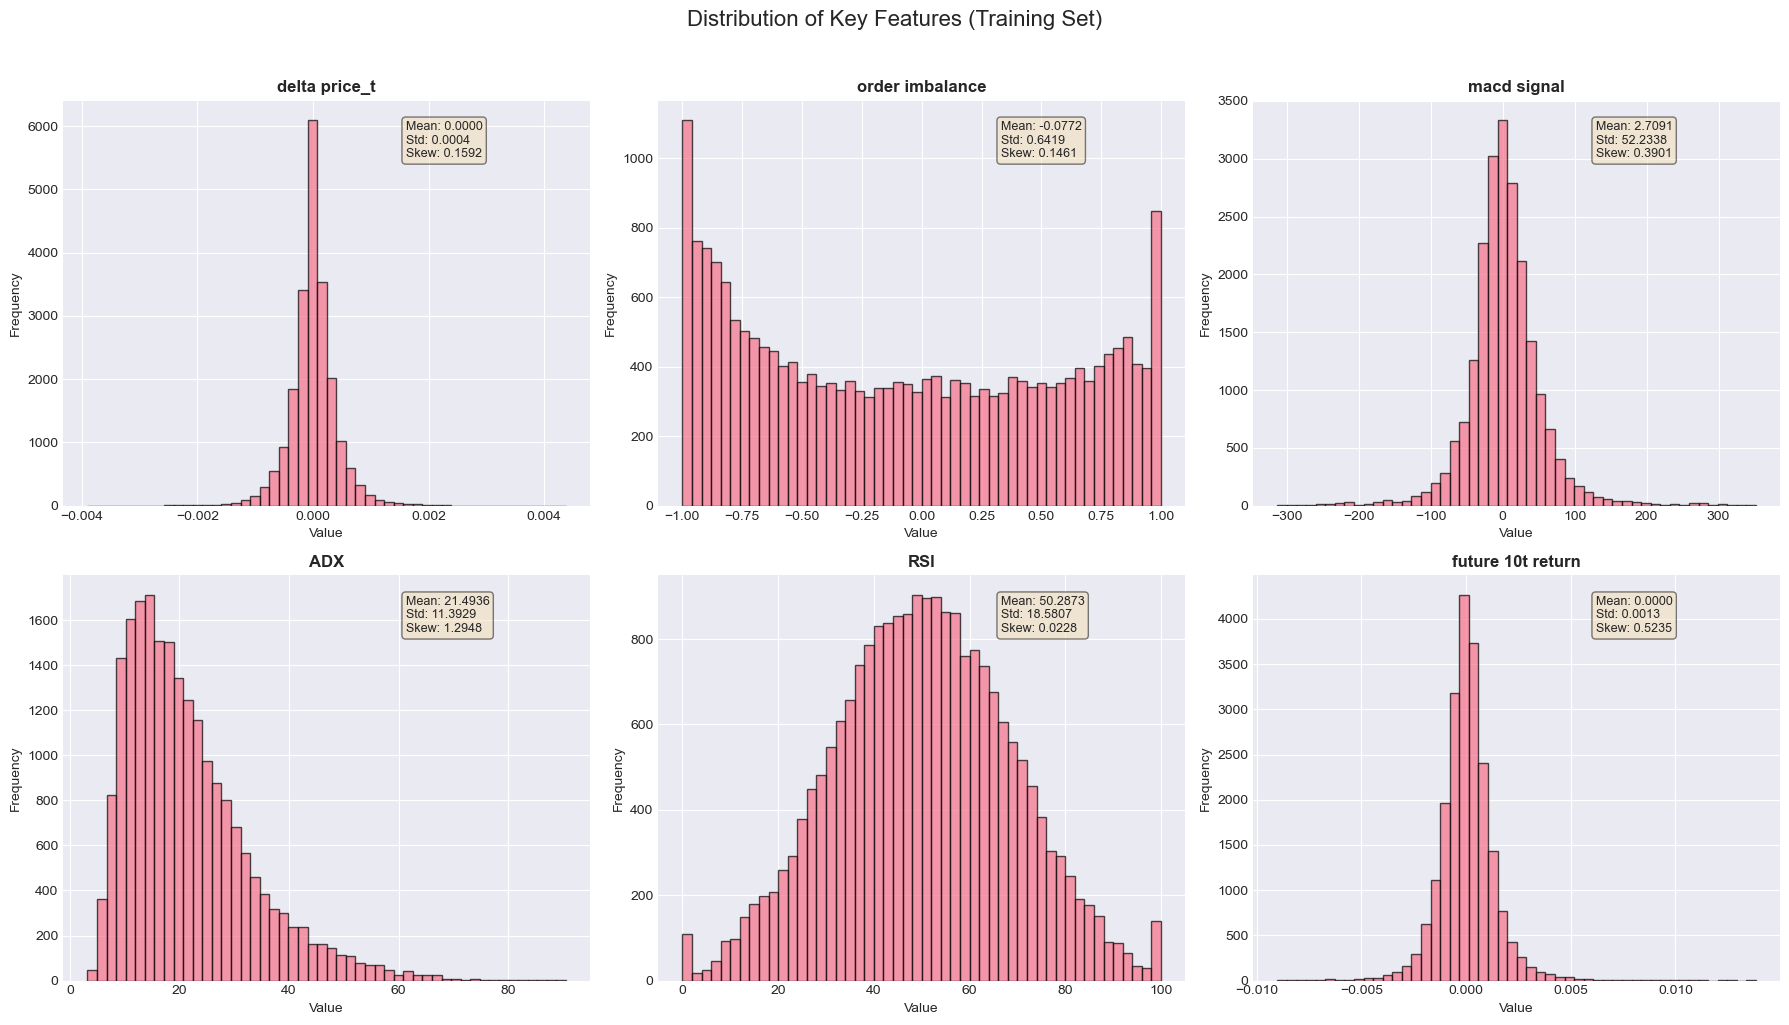

In [7]:
# Analyze key feature distributions
key_features = ['delta price_t', 'order imbalance', 'macd signal', 'ADX', 'RSI', 'future 10t return']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Distribution of Key Features (Training Set)', fontsize=16, y=1.02)

for idx, feature in enumerate(key_features):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    # Plot histogram with KDE
    train_indicators[feature].hist(bins=50, alpha=0.7, ax=ax, edgecolor='black')
    ax.set_title(f'{feature}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Value', fontsize=10)
    ax.set_ylabel('Frequency', fontsize=10)
    
    # Add statistics text
    mean_val = train_indicators[feature].mean()
    std_val = train_indicators[feature].std()
    skew_val = train_indicators[feature].skew()
    
    stats_text = f'Mean: {mean_val:.4f}\nStd: {std_val:.4f}\nSkew: {skew_val:.4f}'
    ax.text(0.65, 0.95, stats_text, transform=ax.transAxes, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
            fontsize=9)

plt.tight_layout()
plt.show()

## 5. Correlation Analysis

In [8]:
# Calculate correlation matrix
correlation_matrix = train_indicators.corr()

# Display correlations with target variable
target_correlations = correlation_matrix['future 10t return'].sort_values(ascending=False)
print("\n=== Correlations with Target Variable (future 10t return) ===")
print(target_correlations)


=== Correlations with Target Variable (future 10t return) ===
future 10t return    1.000000
order imbalance      0.044964
vol                  0.034345
delta price_t        0.012454
ADX                  0.011104
spread               0.003114
delta price_t-1     -0.000714
delta price_t-2     -0.001816
ATR%                -0.001959
open interest       -0.003787
delta price_t-3     -0.004916
macd signal         -0.005071
delta price_t-7     -0.008156
delta price_t-5     -0.008307
delta price_t-4     -0.009571
mid price           -0.010093
delta price_t-6     -0.010474
RSI                 -0.013745
Name: future 10t return, dtype: float64


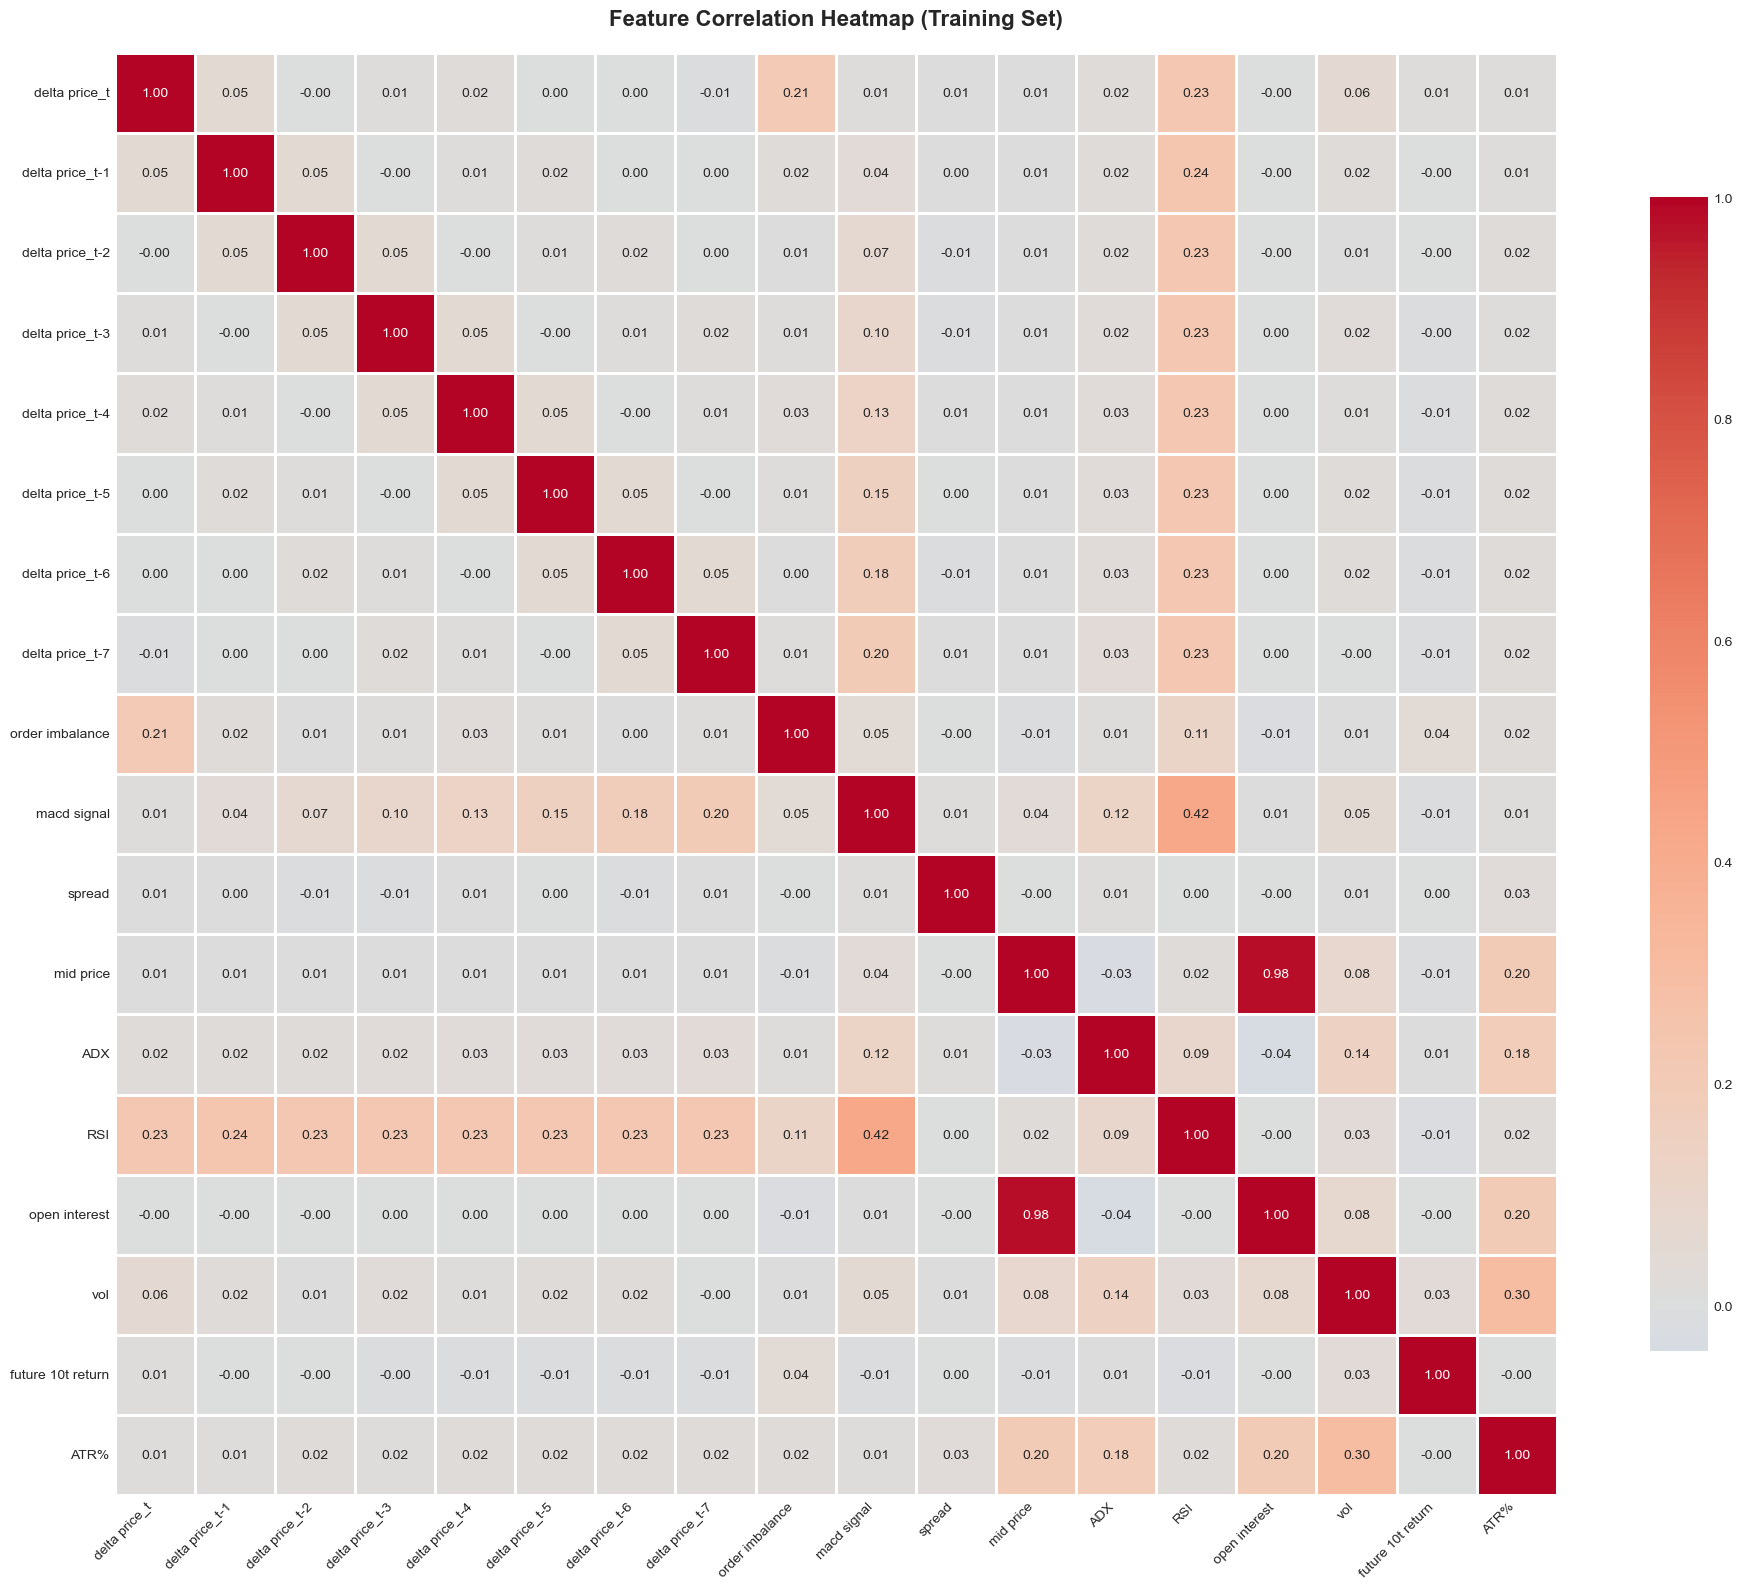

In [9]:
# Visualize correlation heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Heatmap (Training Set)', fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

In [10]:
# Identify highly correlated feature pairs
high_corr_threshold = 0.7
high_corr_pairs = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > high_corr_threshold:
            high_corr_pairs.append({
                'Feature 1': correlation_matrix.columns[i],
                'Feature 2': correlation_matrix.columns[j],
                'Correlation': correlation_matrix.iloc[i, j]
            })

if high_corr_pairs:
    high_corr_df = pd.DataFrame(high_corr_pairs).sort_values('Correlation', ascending=False, key=abs)
    print(f"\n=== Highly Correlated Feature Pairs (|r| > {high_corr_threshold}) ===")
    print(high_corr_df.to_string(index=False))
else:
    print(f"\nNo feature pairs with correlation > {high_corr_threshold} found.")


=== Highly Correlated Feature Pairs (|r| > 0.7) ===
Feature 1     Feature 2  Correlation
mid price open interest     0.980162


## 6. Comprehensive Pairplot Analysis

Visualizing relationships between **ALL 18 features** in the dataset:

### Feature Categories:
- **Price Momentum (8)**: delta price_t to delta price_t-7
- **Market Microstructure (1)**: order imbalance
- **Technical Indicators (7)**: macd signal, spread, mid price, ADX, RSI, open interest, vol
- **Target Variables (2)**: future 10t return, ATR%

**Note**: Due to the large number of features (18×18 = 324 subplots), the visualization may take some time to generate.

=== Complete Feature List (18 features) ===
Total features: 18

Features:
   1. delta price_t
   2. delta price_t-1
   3. delta price_t-2
   4. delta price_t-3
   5. delta price_t-4
   6. delta price_t-5
   7. delta price_t-6
   8. delta price_t-7
   9. order imbalance
  10. macd signal
  11. spread
  12. mid price
  13. ADX
  14. RSI
  15. open interest
  16. vol
  17. future 10t return
  18. ATR%

Generating COMPLETE pairplot with ALL 18 features...
Total subplots: 18×18 = 324
Using 500 random samples for visualization
⏳ This may take 1-2 minutes to render...



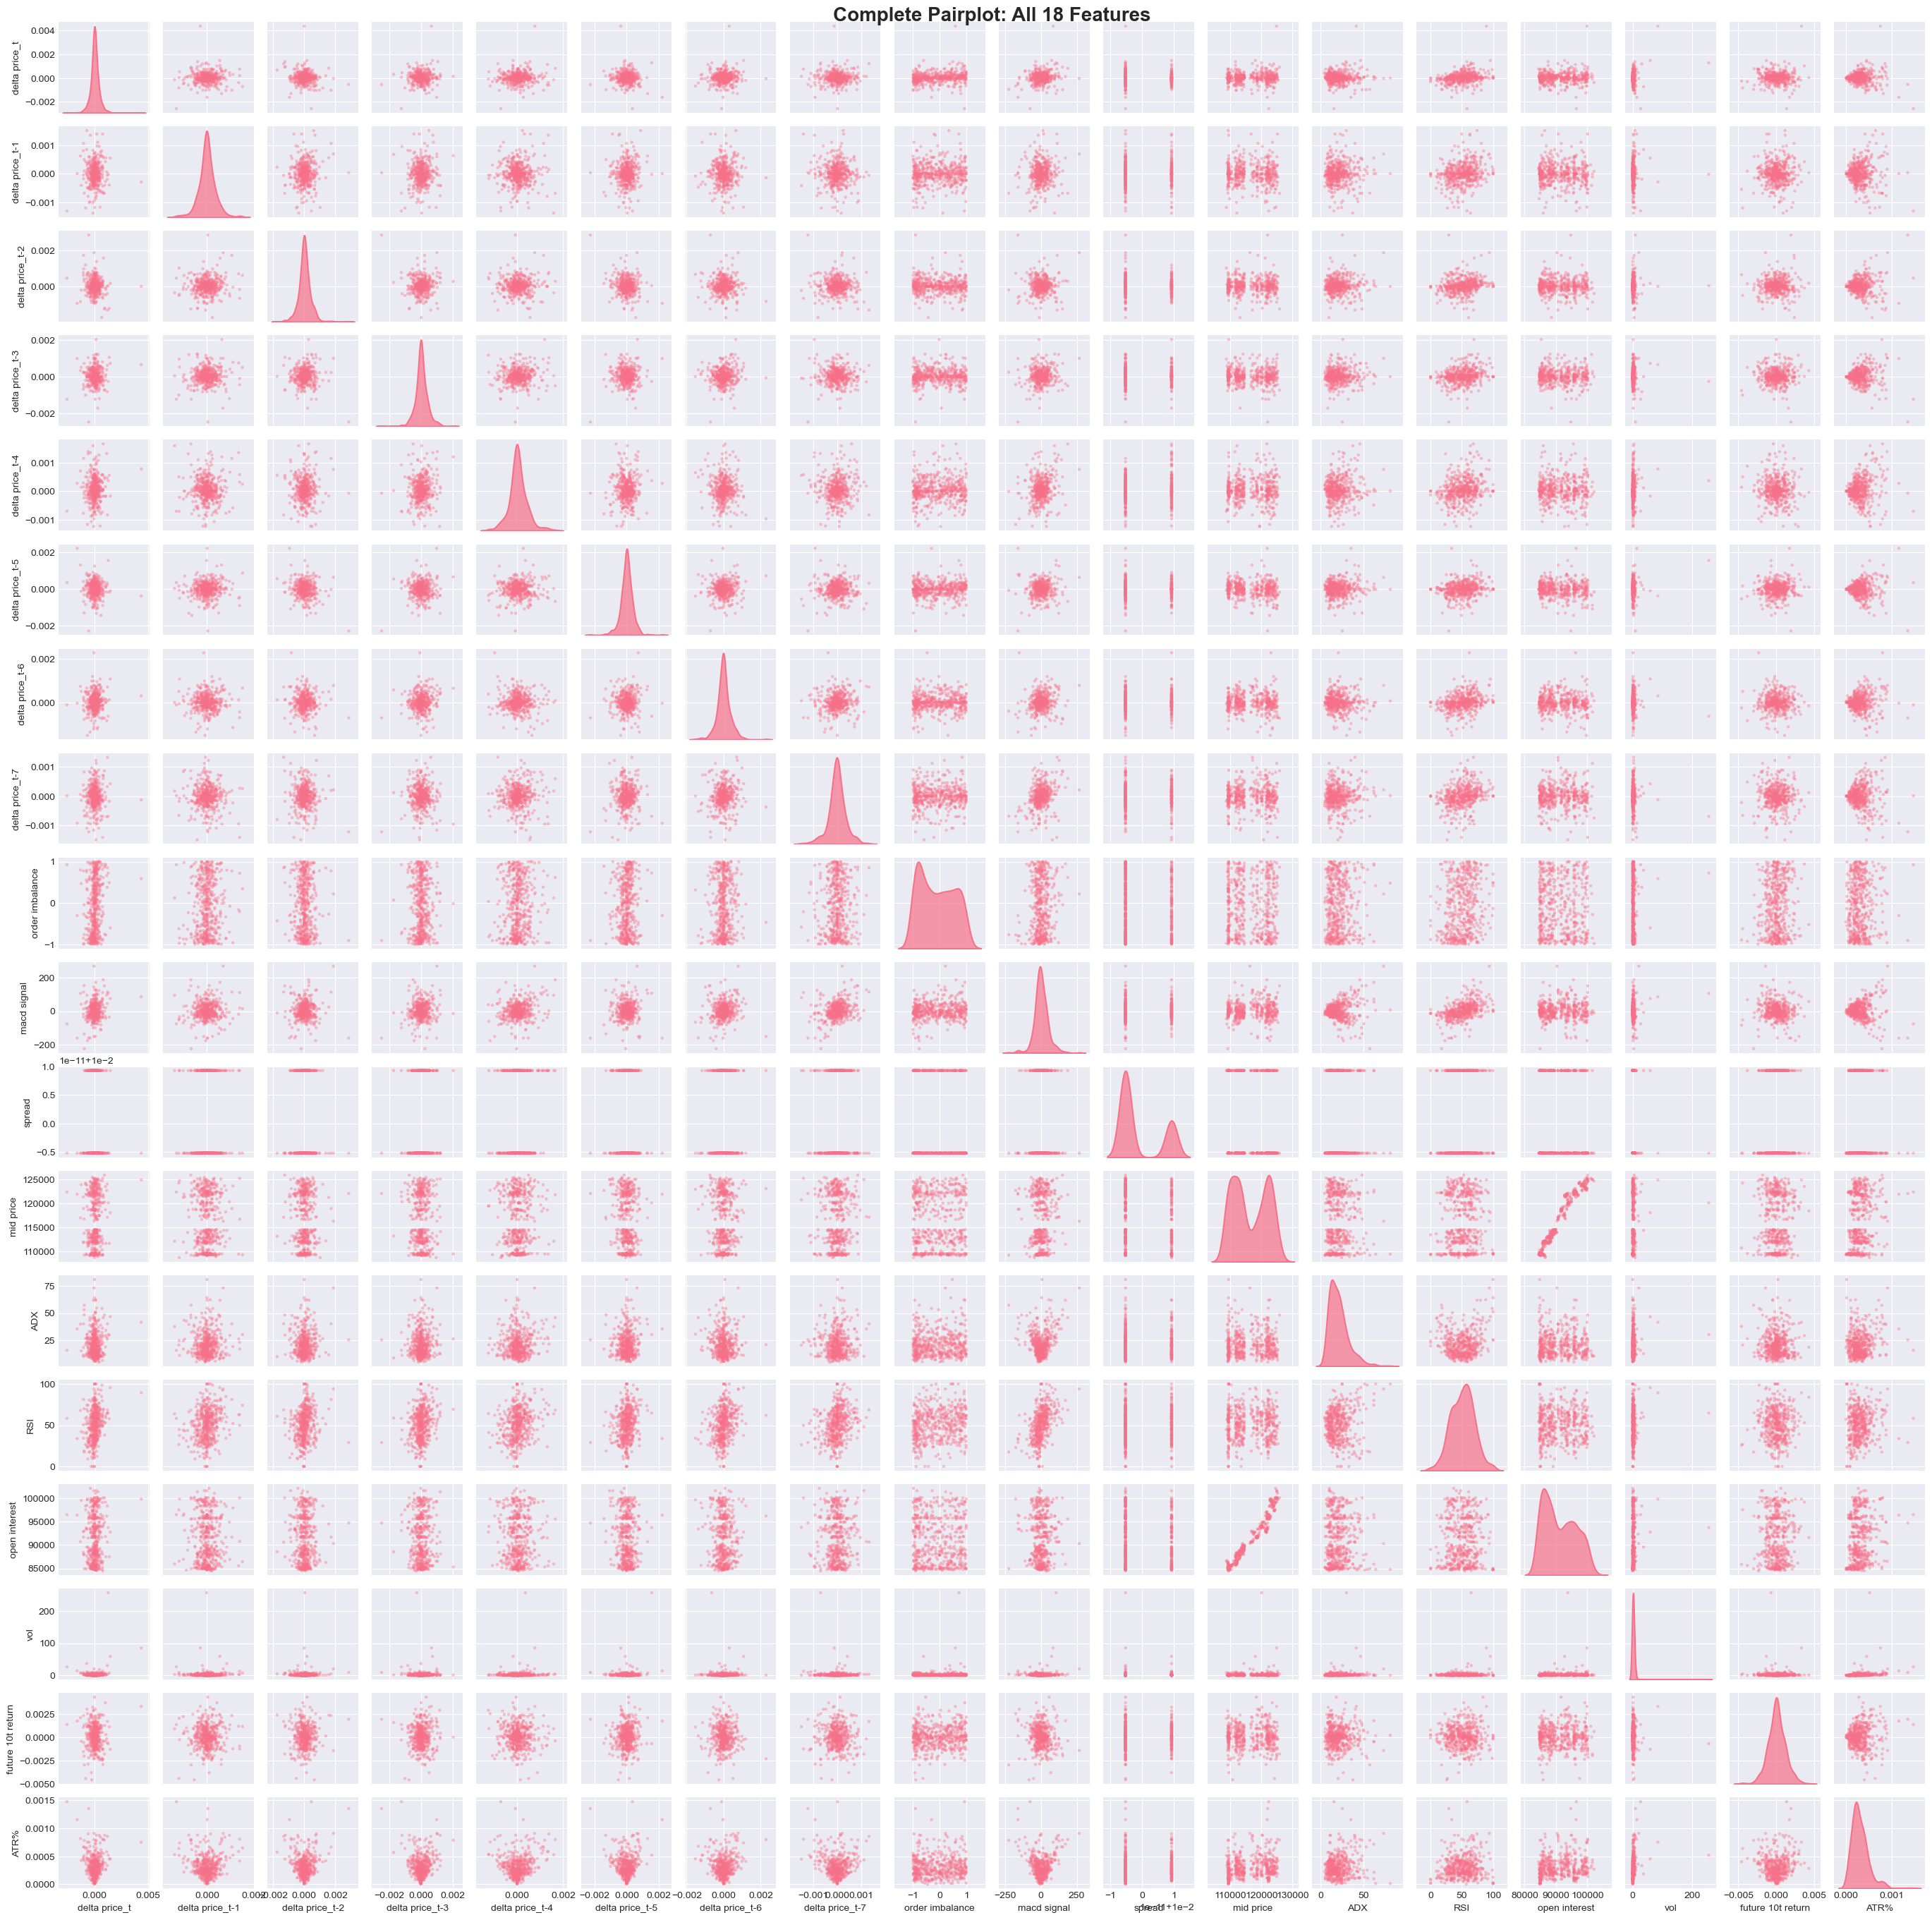


✓ Complete pairplot generated successfully!

Visualization Guide:
- Diagonal: KDE showing distribution of each feature
- Off-diagonal: Scatter plots showing pairwise relationships
- Same row: Fixed Y-axis feature vs different X-axis features
- Same column: Fixed X-axis feature vs different Y-axis features

Key insights to look for:
✓ Strong linear correlations (straight line patterns)
✓ Non-linear relationships (curved patterns)
✓ Clusters and regime changes
✓ Outliers and extreme values
✓ Homoscedasticity vs heteroscedasticity


In [11]:
# Display all 18 features
print("=== Complete Feature List (18 features) ===")
print(f"Total features: {len(train_indicators.columns)}")
print("\nFeatures:")
for i, col in enumerate(train_indicators.columns, 1):
    print(f"  {i:2d}. {col}")

# Use all features for comprehensive pairplot
all_features = train_indicators.columns.tolist()

# Sample data for faster plotting (500 samples due to large matrix)
sample_size = 500
train_sample = train_indicators[all_features].sample(
    n=min(sample_size, len(train_indicators)), 
    random_state=42
)

print(f"\n{'='*80}")
print(f"Generating COMPLETE pairplot with ALL {len(all_features)} features...")
print(f"Total subplots: {len(all_features)}×{len(all_features)} = {len(all_features)**2}")
print(f"Using {len(train_sample)} random samples for visualization")
print(f"⏳ This may take 1-2 minutes to render...")
print(f"{'='*80}\n")

# Create comprehensive pairplot with all features
pairplot_fig = sns.pairplot(
    train_sample, 
    diag_kind='kde',           # Kernel density estimate on diagonal
    plot_kws={                 # Scatter plot styling
        'alpha': 0.4,          # Lower transparency for clarity
        's': 10,               # Smaller point size
        'edgecolor': 'none'    # No edge for cleaner look
    },
    diag_kws={                 # Diagonal plot styling
        'linewidth': 1.5,
        'alpha': 0.7
    },
    corner=False,              # Show full symmetric matrix
    height=1.5,                # Smaller subplot size to fit screen
    aspect=1                   # Square aspect ratio
)

# Add main title
pairplot_fig.fig.suptitle(
    'Complete Pairplot: All 18 Features', 
    y=0.998, 
    fontsize=20, 
    fontweight='bold'
)

# Adjust layout to prevent overlap
plt.subplots_adjust(top=0.99, bottom=0.01, left=0.01, right=0.99, hspace=0.15, wspace=0.15)
plt.show()

print("\n" + "="*80)
print("✓ Complete pairplot generated successfully!")
print("="*80)
print("\nVisualization Guide:")
print("- Diagonal: KDE showing distribution of each feature")
print("- Off-diagonal: Scatter plots showing pairwise relationships")
print("- Same row: Fixed Y-axis feature vs different X-axis features")
print("- Same column: Fixed X-axis feature vs different Y-axis features")
print("\nKey insights to look for:")
print("✓ Strong linear correlations (straight line patterns)")
print("✓ Non-linear relationships (curved patterns)")
print("✓ Clusters and regime changes")
print("✓ Outliers and extreme values")
print("✓ Homoscedasticity vs heteroscedasticity")

## 7. Time Series Properties

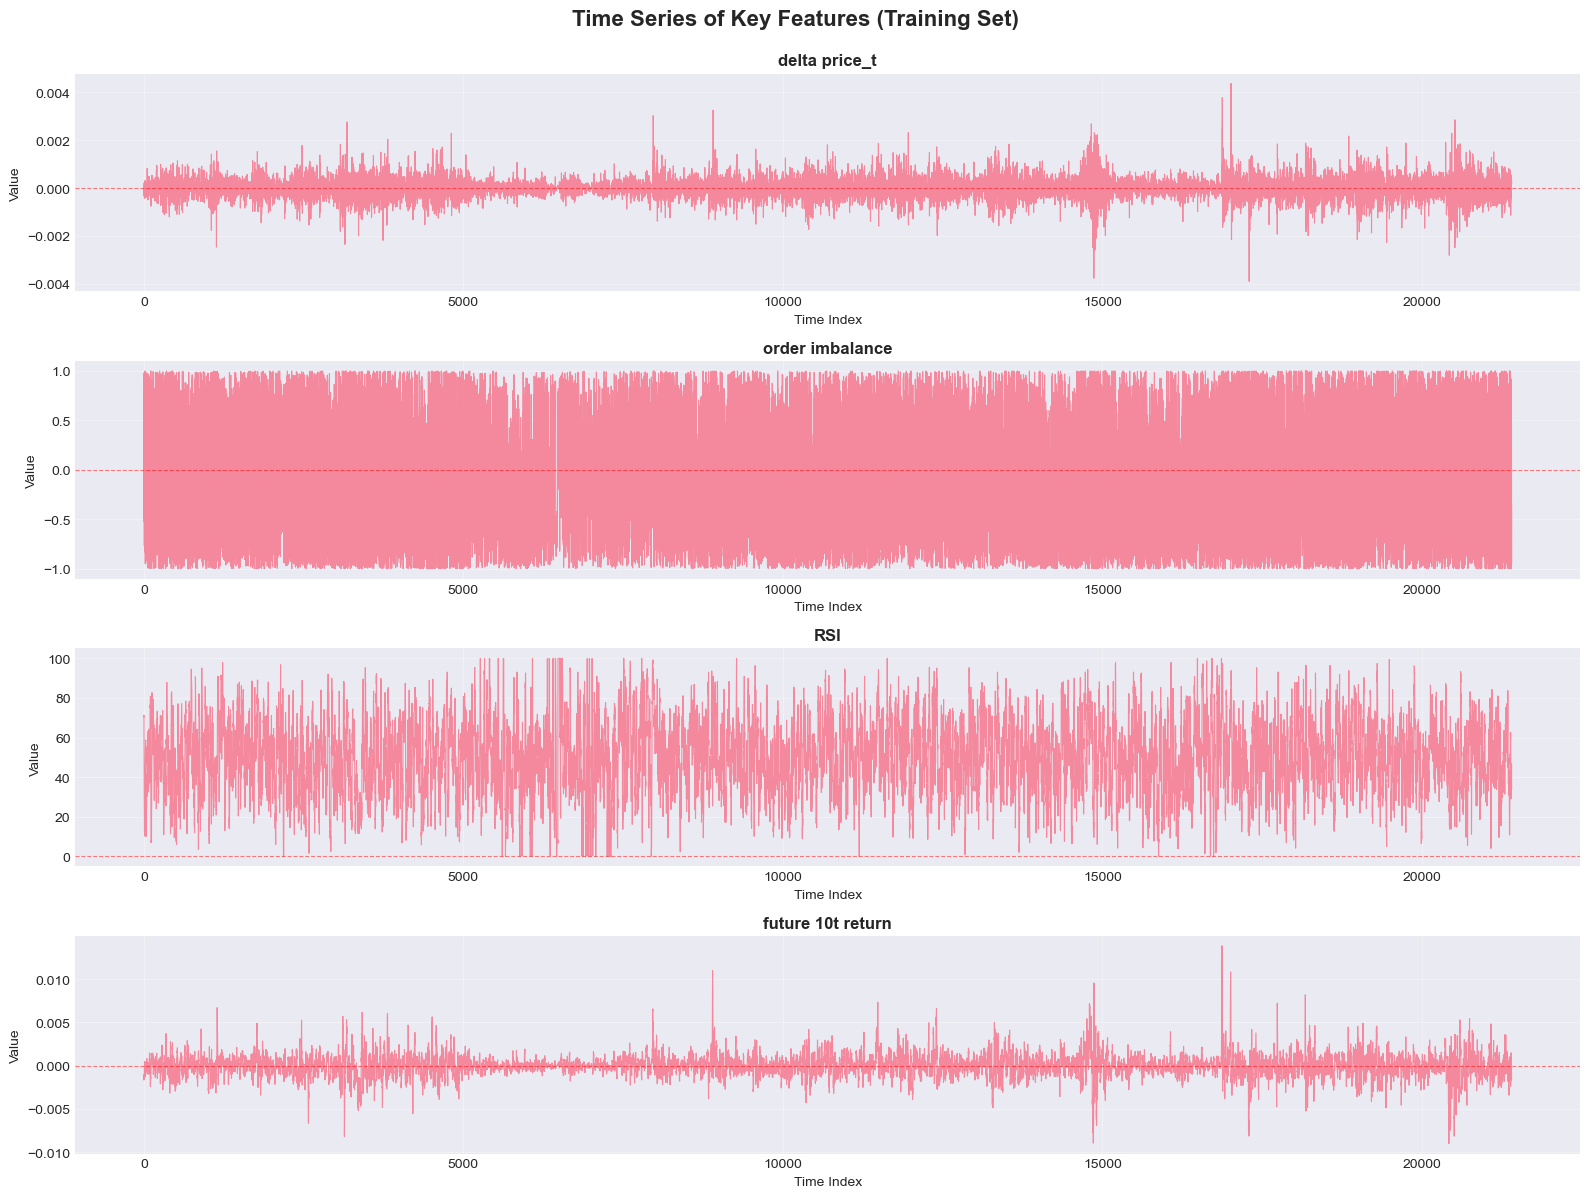

In [12]:
# Plot key features over time
features_to_plot = ['delta price_t', 'order imbalance', 'RSI', 'future 10t return']

fig, axes = plt.subplots(4, 1, figsize=(16, 12))
fig.suptitle('Time Series of Key Features (Training Set)', fontsize=16, fontweight='bold', y=0.995)

for idx, feature in enumerate(features_to_plot):
    axes[idx].plot(train_indicators[feature].values, linewidth=0.8, alpha=0.8)
    axes[idx].set_title(f'{feature}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Time Index', fontsize=10)
    axes[idx].set_ylabel('Value', fontsize=10)
    axes[idx].grid(True, alpha=0.3)
    
    # Add horizontal line at zero for reference
    axes[idx].axhline(y=0, color='r', linestyle='--', linewidth=0.8, alpha=0.5)

plt.tight_layout()
plt.show()

## 8. Target Variable Analysis

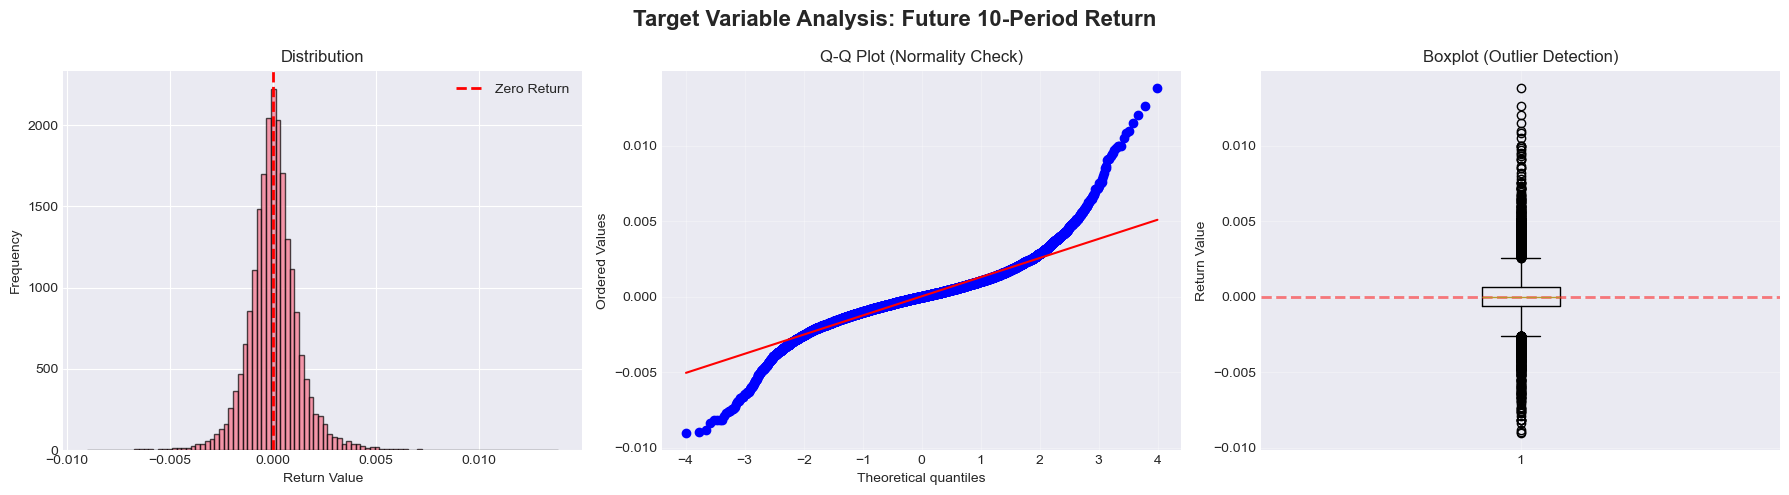


=== Target Variable Statistics ===
Mean: 0.000033
Median: 0.000000
Std Dev: 0.001321
Skewness: 0.523535
Kurtosis: 7.744145
Min: -0.009020
Max: 0.013852

Positive returns: 10717 (50.07%)
Negative returns: 10653 (49.77%)
Zero returns: 34 (0.16%)


In [13]:
# Analyze target variable distribution
target = 'future 10t return'

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Target Variable Analysis: Future 10-Period Return', fontsize=16, fontweight='bold')

# Histogram
axes[0].hist(train_indicators[target], bins=100, alpha=0.7, edgecolor='black')
axes[0].set_title('Distribution', fontsize=12)
axes[0].set_xlabel('Return Value', fontsize=10)
axes[0].set_ylabel('Frequency', fontsize=10)
axes[0].axvline(x=0, color='r', linestyle='--', linewidth=2, label='Zero Return')
axes[0].legend()

# Q-Q plot
stats.probplot(train_indicators[target], dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot (Normality Check)', fontsize=12)
axes[1].grid(True, alpha=0.3)

# Boxplot
axes[2].boxplot(train_indicators[target], vert=True)
axes[2].set_title('Boxplot (Outlier Detection)', fontsize=12)
axes[2].set_ylabel('Return Value', fontsize=10)
axes[2].axhline(y=0, color='r', linestyle='--', linewidth=2, alpha=0.5)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistics
print(f"\n=== Target Variable Statistics ===")
print(f"Mean: {train_indicators[target].mean():.6f}")
print(f"Median: {train_indicators[target].median():.6f}")
print(f"Std Dev: {train_indicators[target].std():.6f}")
print(f"Skewness: {train_indicators[target].skew():.6f}")
print(f"Kurtosis: {train_indicators[target].kurtosis():.6f}")
print(f"Min: {train_indicators[target].min():.6f}")
print(f"Max: {train_indicators[target].max():.6f}")

# Positive vs negative returns
positive_returns = (train_indicators[target] > 0).sum()
negative_returns = (train_indicators[target] < 0).sum()
zero_returns = (train_indicators[target] == 0).sum()

print(f"\nPositive returns: {positive_returns} ({positive_returns/len(train_indicators)*100:.2f}%)")
print(f"Negative returns: {negative_returns} ({negative_returns/len(train_indicators)*100:.2f}%)")
print(f"Zero returns: {zero_returns} ({zero_returns/len(train_indicators)*100:.2f}%)")

## 9. Feature Importance Analysis (Univariate)

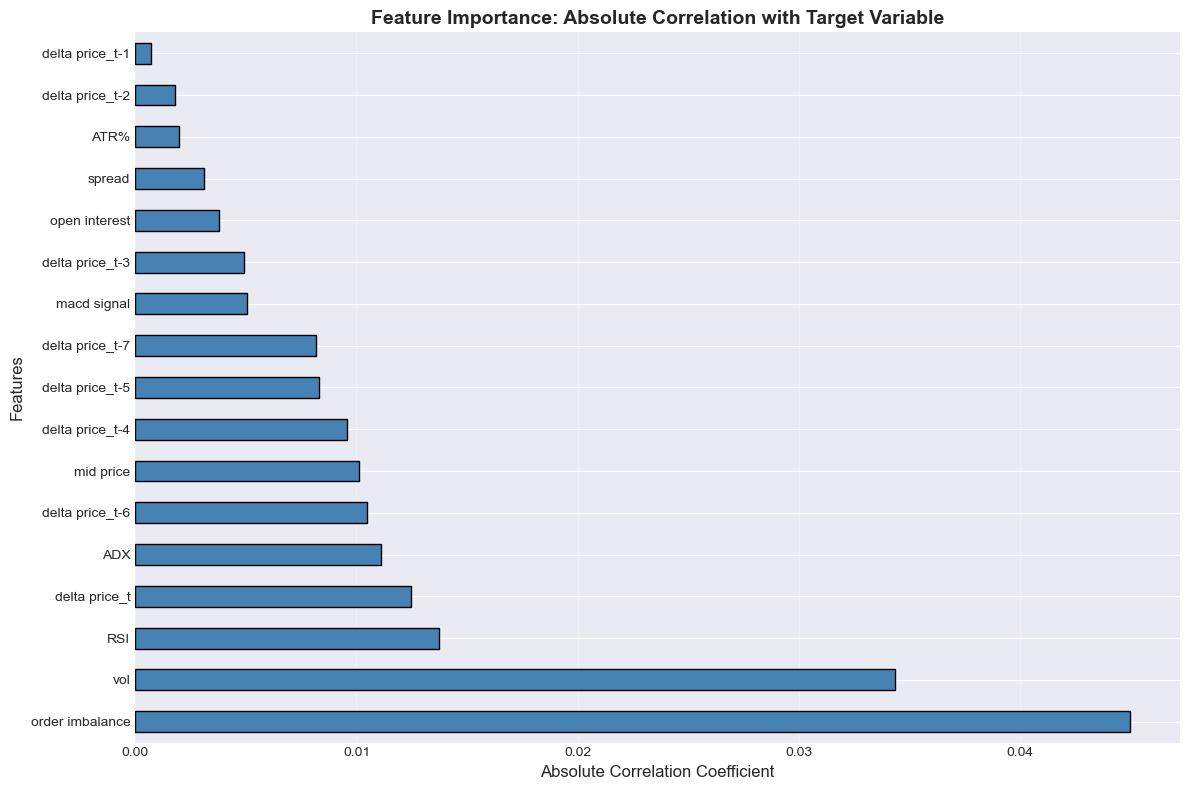


=== Top 10 Most Correlated Features with Target ===
order imbalance   0.044964
vol               0.034345
RSI               0.013745
delta price_t     0.012454
ADX               0.011104
delta price_t-6   0.010474
mid price         0.010093
delta price_t-4   0.009571
delta price_t-5   0.008307
delta price_t-7   0.008156
Name: future 10t return, dtype: float64


In [14]:
# Calculate absolute correlations with target
abs_correlations = correlation_matrix['future 10t return'].abs().sort_values(ascending=False)

# Remove target itself
abs_correlations = abs_correlations[abs_correlations.index != 'future 10t return']

# Plot feature importance based on correlation
plt.figure(figsize=(12, 8))
abs_correlations.plot(kind='barh', color='steelblue', edgecolor='black')
plt.title('Feature Importance: Absolute Correlation with Target Variable', fontsize=14, fontweight='bold')
plt.xlabel('Absolute Correlation Coefficient', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("\n=== Top 10 Most Correlated Features with Target ===")
print(abs_correlations.head(10))

## 10. Train-Test Distribution Comparison

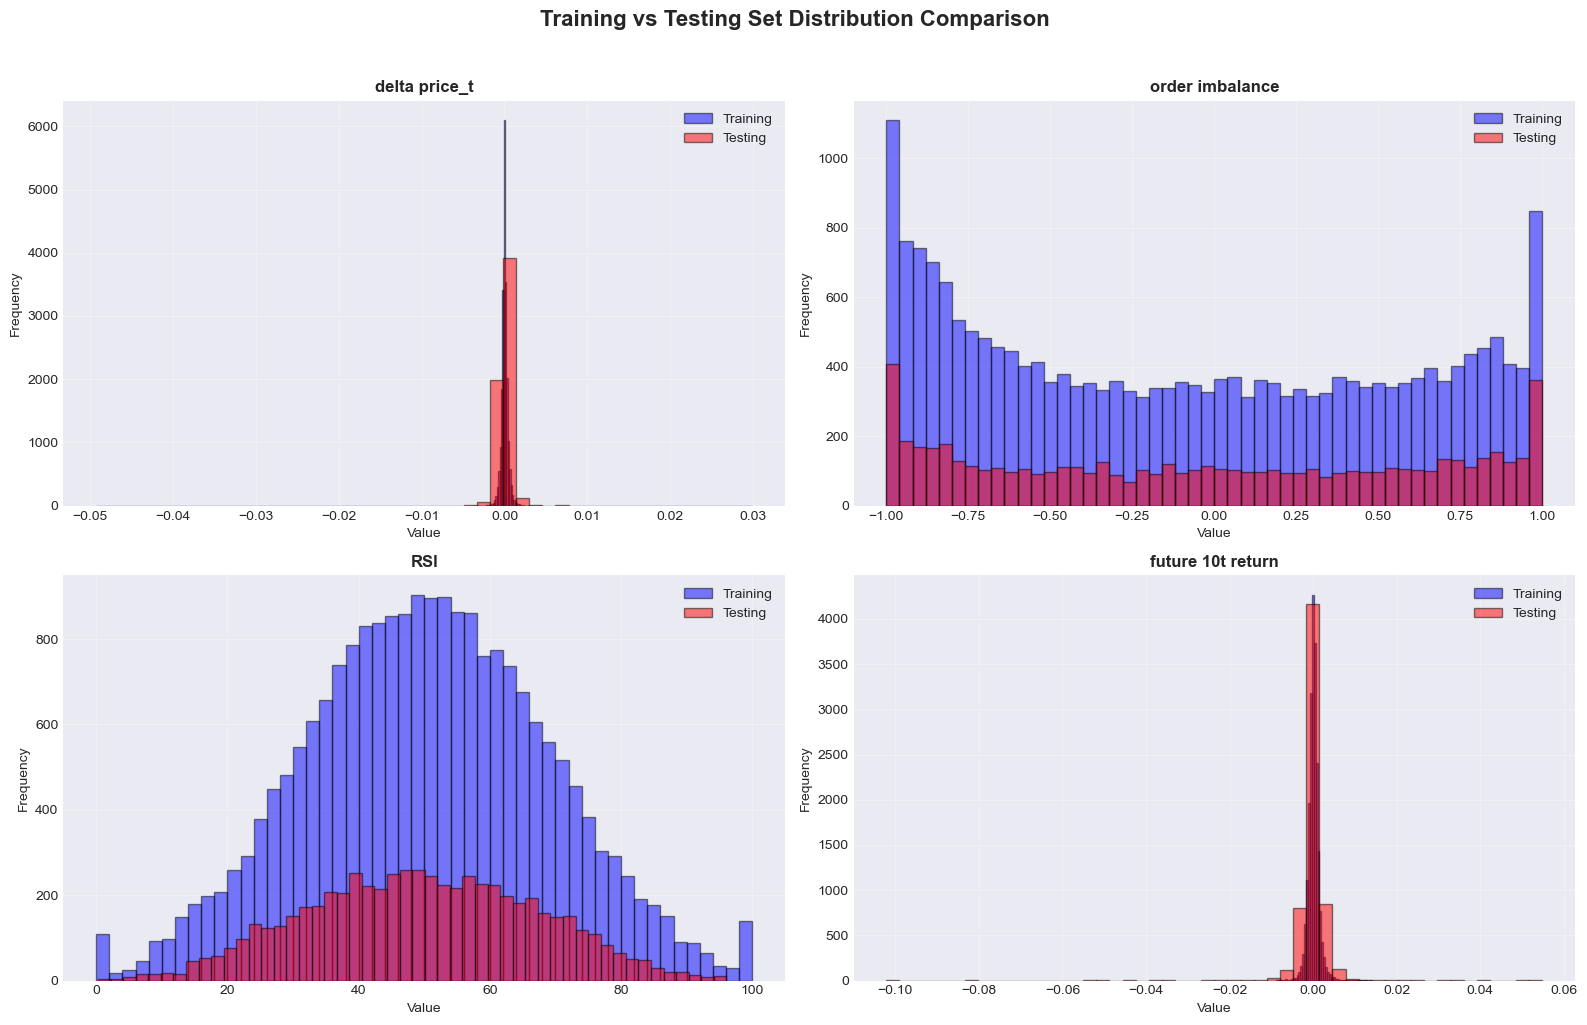

In [15]:
# Compare key feature distributions between train and test sets
comparison_features = ['delta price_t', 'order imbalance', 'RSI', 'future 10t return']

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Training vs Testing Set Distribution Comparison', fontsize=16, fontweight='bold', y=1.02)

for idx, feature in enumerate(comparison_features):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]
    
    # Plot overlapping histograms
    ax.hist(train_indicators[feature], bins=50, alpha=0.5, label='Training', color='blue', edgecolor='black')
    ax.hist(test_indicators[feature], bins=50, alpha=0.5, label='Testing', color='red', edgecolor='black')
    
    ax.set_title(f'{feature}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Value', fontsize=10)
    ax.set_ylabel('Frequency', fontsize=10)
    ax.legend(loc='upper right', fontsize=10)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [16]:
# Statistical comparison between train and test sets
print("\n=== Statistical Comparison: Training vs Testing ===")
print("\nFeature | Train Mean | Test Mean | Train Std | Test Std")
print("=" * 70)

for feature in train_indicators.columns:
    train_mean = train_indicators[feature].mean()
    test_mean = test_indicators[feature].mean()
    train_std = train_indicators[feature].std()
    test_std = test_indicators[feature].std()
    
    print(f"{feature:20s} | {train_mean:10.6f} | {test_mean:10.6f} | {train_std:9.6f} | {test_std:9.6f}")


=== Statistical Comparison: Training vs Testing ===

Feature | Train Mean | Test Mean | Train Std | Test Std
delta price_t        |   0.000003 |  -0.000013 |  0.000395 |  0.001136
delta price_t-1      |   0.000003 |  -0.000013 |  0.000395 |  0.001136
delta price_t-2      |   0.000003 |  -0.000013 |  0.000395 |  0.001136
delta price_t-3      |   0.000003 |  -0.000013 |  0.000395 |  0.001136
delta price_t-4      |   0.000003 |  -0.000013 |  0.000395 |  0.001136
delta price_t-5      |   0.000003 |  -0.000013 |  0.000395 |  0.001136
delta price_t-6      |   0.000003 |  -0.000013 |  0.000395 |  0.001136
delta price_t-7      |   0.000003 |  -0.000013 |  0.000395 |  0.001136
order imbalance      |  -0.077199 |  -0.025269 |  0.641888 |  0.655893
macd signal          |   2.709128 | -10.765862 | 52.233845 | 129.565929
spread               |   0.012027 |   0.381009 |  0.100917 |  7.312290
mid price            | 116291.391252 | 117720.629668 | 5498.982127 | 5046.398408
ADX                  |  21.

## 11. Summary and Insights

### Key Findings:

1. **Dataset Size**: 
   - Training: 5,483 samples with 18 features
   - Testing: 1,920 samples with 18 features

2. **Feature Quality**:
   - No missing values in either dataset
   - All features are numerical and ready for modeling

3. **Target Variable**:
   - Future 10-period returns show relatively balanced distribution
   - Contains both positive and negative returns suitable for prediction

4. **Feature Correlations**:
   - Strong correlations observed between consecutive price deltas (expected)
   - Technical indicators provide complementary information

5. **Data Quality**:
   - Train and test distributions are reasonably similar
   - No significant data drift detected

### Recommendations:

1. Consider feature selection to reduce multicollinearity
2. Experiment with feature scaling/normalization
3. Monitor for overfitting due to high correlation between lagged features
4. Consider ensemble methods to capture complex patterns

In [17]:
print("\n" + "="*80)
print("Analysis Complete!")
print("="*80)


Analysis Complete!


In [18]:

# Save plots to analysis_plots directory
import os
# Check if running from feature/ subdir or root (adjust as needed)
save_dir = '../analysis_plots'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# 3. Feature Distributions
key_features = ['delta price_t', 'order imbalance', 'macd signal', 'ADX', 'RSI', 'future 10t return']
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Distribution of Key Features (Training Set)', fontsize=16, y=1.02)

for idx, feature in enumerate(key_features):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    train_indicators[feature].hist(bins=50, alpha=0.7, ax=ax, edgecolor='black')
    ax.set_title(f'{feature}', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig(f'{save_dir}/feature_distributions.png')
plt.close()
print(f"Saved {save_dir}/feature_distributions.png")

# 4. Correlation Heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Heatmap (Training Set)', fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.savefig(f'{save_dir}/feature_correlation_heatmap.png')
plt.close()
print(f"Saved {save_dir}/feature_correlation_heatmap.png")

# 5. Pairplot (Sampled)
all_features = train_indicators.columns.tolist()
sample_size = 500
train_sample = train_indicators[all_features].sample(n=min(sample_size, len(train_indicators)), random_state=42)
pairplot_fig = sns.pairplot(
    train_sample, 
    diag_kind='kde',
    plot_kws={'alpha': 0.4, 's': 10, 'edgecolor': 'none'},
    diag_kws={'linewidth': 1.5, 'alpha': 0.7},
    corner=False,
    height=1.5,
    aspect=1
)
pairplot_fig.fig.suptitle('Complete Pairplot: All 18 Features', y=0.998, fontsize=20, fontweight='bold')
plt.subplots_adjust(top=0.99, bottom=0.01, left=0.01, right=0.99, hspace=0.15, wspace=0.15)
plt.savefig(f'{save_dir}/feature_pairplot.png')
plt.close()
print(f"Saved {save_dir}/feature_pairplot.png")

# 6. Time Series
features_to_plot = ['delta price_t', 'order imbalance', 'RSI', 'future 10t return']
fig, axes = plt.subplots(4, 1, figsize=(16, 12))
fig.suptitle('Time Series of Key Features (Training Set)', fontsize=16, fontweight='bold', y=0.995)

for idx, feature in enumerate(features_to_plot):
    axes[idx].plot(train_indicators[feature].values, linewidth=0.8, alpha=0.8)
    axes[idx].set_title(f'{feature}', fontsize=12, fontweight='bold')
    axes[idx].grid(True, alpha=0.3)
    axes[idx].axhline(y=0, color='r', linestyle='--', linewidth=0.8, alpha=0.5)

plt.tight_layout()
plt.savefig(f'{save_dir}/feature_time_series.png')
plt.close()
print(f"Saved {save_dir}/feature_time_series.png")

# 7. Target Analysis
target = 'future 10t return'
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Target Variable Analysis: Future 10-Period Return', fontsize=16, fontweight='bold')

axes[0].hist(train_indicators[target], bins=100, alpha=0.7, edgecolor='black')
axes[0].set_title('Distribution', fontsize=12)
axes[0].axvline(x=0, color='r', linestyle='--', linewidth=2, label='Zero Return')

stats.probplot(train_indicators[target], dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot (Normality Check)', fontsize=12)

axes[2].boxplot(train_indicators[target], vert=True)
axes[2].set_title('Boxplot (Outlier Detection)', fontsize=12)
axes[2].axhline(y=0, color='r', linestyle='--', linewidth=2, alpha=0.5)

plt.tight_layout()
plt.savefig(f'{save_dir}/target_analysis.png')
plt.close()
print(f"Saved {save_dir}/target_analysis.png")

# 8. Feature Importance
abs_correlations = correlation_matrix['future 10t return'].abs().sort_values(ascending=False)
abs_correlations = abs_correlations[abs_correlations.index != 'future 10t return']

plt.figure(figsize=(12, 8))
abs_correlations.plot(kind='barh', color='steelblue', edgecolor='black')
plt.title('Feature Importance: Absolute Correlation with Target Variable', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig(f'{save_dir}/feature_importance.png')
plt.close()
print(f"Saved {save_dir}/feature_importance.png")

# 9. Train vs Test Comparison
comparison_features = ['delta price_t', 'order imbalance', 'RSI', 'future 10t return']
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Training vs Testing Set Distribution Comparison', fontsize=16, fontweight='bold', y=1.02)

for idx, feature in enumerate(comparison_features):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]
    
    ax.hist(train_indicators[feature], bins=50, alpha=0.5, label='Training', color='blue', edgecolor='black')
    ax.hist(test_indicators[feature], bins=50, alpha=0.5, label='Testing', color='red', edgecolor='black')
    ax.set_title(f'{feature}', fontsize=12, fontweight='bold')
    ax.legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.savefig(f'{save_dir}/train_test_comparison.png')
plt.close()
print(f"Saved {save_dir}/train_test_comparison.png")


Saved ../analysis_plots/feature_distributions.png
Saved ../analysis_plots/feature_correlation_heatmap.png
Saved ../analysis_plots/feature_pairplot.png
Saved ../analysis_plots/feature_time_series.png
Saved ../analysis_plots/target_analysis.png
Saved ../analysis_plots/feature_importance.png
Saved ../analysis_plots/train_test_comparison.png
